In [68]:

import pandas as pd
import pickle
import numpy as np
import os
from utils import *
from tqdm.auto import tqdm

from flaml import AutoML
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# plt.style.use(['ipynb', 'use_mathtext', 'colors5-light', 'science'])
# sns.set_style("whitegrid")
# sns.set_palette("RdBu")
# sns.set(
#     rc={'text.usetex': True},
#     font="serif",
#     font_scale=1.2
# )

# matplotlib.rcParams['font.sans-serif'] = ['SimHei']
# matplotlib.rcParams['font.serif'] = ['SimHei']
# sns.set_style("darkgrid", {"font.sans-serif": ['simhei', 'Arial']})

sns.set_context('notebook')
plt.rcParams['font.family'] = ['Arial Unicode MS']

# preprocess and load data
filepath = 'train_data.pkl'
if not os.path.exists(filepath):
    general_process(output_filepath=filepath)
with open(filepath, 'rb') as fin:
    df = pickle.load(fin)
df.head(1)

# compute 'flux_density_max'
df['flux_density_max'] = df['flux_density'].apply(lambda r: np.max(r))

# Prepare features and target
X_train = df[['type_material', 'temp', 'freq', 'type_waveform', 'flux_density_max']]
y_train = df['core_loss']

In [71]:
# Encode categorical variables
label_encoders = {}
for col in ['type_material', 'type_waveform']:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    label_encoders[col] = le

# Define AutoML settings
automl_settings = {
    "time_budget": 30,  # in seconds
    "estimator_list": ['lgbm'],
    "metric": 'mae',
    "task": 'regression',
    "log_file_name": "automl.log",
    "early_stop": True,
    "eval_method": "holdout",
    "seed": 20230728,
    "verbose": 3,
    "log_type": "better",
    "ensemble": True
}

# Initialize and train the model
model = AutoML()
model.fit(X_train, y_train, **automl_settings)

# Print the best hyperparameters and MAE
print('Best hyperparameter config:', model.best_config)
print('Best MAE:', model.best_loss)

[flaml.automl.logger: 09-22 22:27:26] {1693} INFO - task = regression
[flaml.automl.logger: 09-22 22:27:26] {1700} INFO - Data split method: uniform
[flaml.automl.logger: 09-22 22:27:26] {1703} INFO - Evaluation method: holdout
[flaml.automl.logger: 09-22 22:27:26] {1801} INFO - Minimizing error metric: mae
[flaml.automl.logger: 09-22 22:27:26] {1911} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 09-22 22:27:26] {2221} INFO - iteration 0, current learner lgbm


/var/folders/hq/mrh1wvlx1r9crbtgy7q4hfbc0000gn/T/ipykernel_79475/3488817729.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = le.fit_transform(X_train[col])
/var/folders/hq/mrh1wvlx1r9crbtgy7q4hfbc0000gn/T/ipykernel_79475/3488817729.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = le.fit_transform(X_train[col])


[flaml.automl.logger: 09-22 22:27:26] {2347} INFO - Estimated sufficient time budget=691s. Estimated necessary time budget=1s.
[flaml.automl.logger: 09-22 22:27:26] {2394} INFO -  at 0.2s,	estimator lgbm's best error=186024.5838,	best estimator lgbm's best error=186024.5838
[flaml.automl.logger: 09-22 22:27:26] {2221} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 09-22 22:27:26] {2394} INFO -  at 0.3s,	estimator lgbm's best error=134342.4478,	best estimator lgbm's best error=134342.4478
[flaml.automl.logger: 09-22 22:27:26] {2221} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 09-22 22:27:27] {2394} INFO -  at 0.3s,	estimator lgbm's best error=134342.4478,	best estimator lgbm's best error=134342.4478
[flaml.automl.logger: 09-22 22:27:27] {2221} INFO - iteration 3, current learner lgbm
[flaml.automl.logger: 09-22 22:27:27] {2394} INFO -  at 0.4s,	estimator lgbm's best error=87542.8051,	best estimator lgbm's best error=87542.8051
[flaml.automl.logger: 09-

In [76]:
demo = np.array([label_encoders['type_material'].transform(['1'])[0],
                 25, 50020,
                 label_encoders['type_waveform'].transform(['正弦波'])[0], 0.031419])
demo = demo.reshape(1, -1)
model.predict(demo)

array([2683.71999151])

array([2683.71999151])

<BarContainer object of 5 artists>

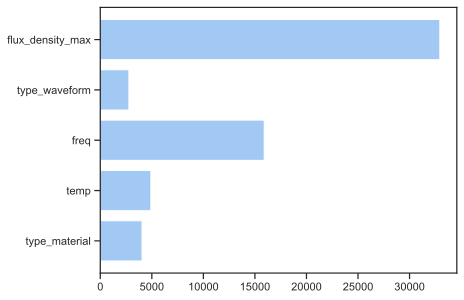

In [73]:
plt.barh(model.feature_names_in_, model.feature_importances_)

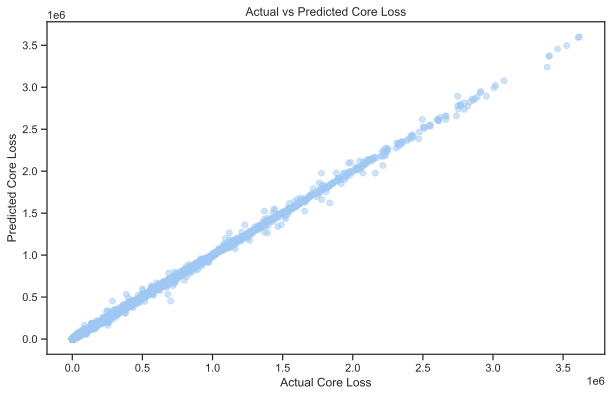

In [74]:
# use the model to predict
y_pred = model.predict(X_train)
# plot the predicted and actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred, alpha=0.5)
plt.xlabel('Actual Core Loss')
plt.ylabel('Predicted Core Loss')
plt.title('Actual vs Predicted Core Loss')
plt.show()

In [75]:
# save the model
with open('model_and_encoders.pkl', 'wb') as f:
    pickle.dump({
        'model': model,
        'label_encoders': label_encoders
    }, f)

In [ ]:
# load the model
with open('model.pkl', 'rb') as fin:
    model = pickle.load(fin)

In [44]:
X_train.head(1)

,type_material,temp,freq,type_waveform,flux_density_max
0,0,25,50030,2,0.028849


In [45]:
test_df = pd.read_excel('dataset/附件三（测试集）.xlsx')
column_mapping = {
    '温度，oC': 'temp',
    '频率，Hz': 'freq',
    '磁芯损耗，w/m3': 'core_loss',
    '0（磁通密度B，T）': 0,
    '励磁波形': 'type_waveform',
    '磁芯材料': 'type_material',
}
test_df.rename(columns=column_mapping, inplace=True)
test_df['flux_density'] = test_df.iloc[:, 5:].values.tolist()
test_df.drop(columns=[i for i in range(1024)], inplace=True)
test_df.head(1)

,序号,temp,freq,type_material,type_waveform,flux_density
0,1,25,56320,材料1,正弦波,"[0.002215526, 0.002596693, 0.002976955, 0.0033..."


In [46]:
# test using the model
test_df['flux_density_max'] = test_df['flux_density'].apply(lambda r: np.max(r))
test_df['type_material'] = test_df['type_material'].apply(lambda r: r.replace('材料', ''))

X_test = test_df[['type_material', 'temp', 'freq', 'type_waveform', 'flux_density_max']]
for col in ['type_material', 'type_waveform']:
    le = label_encoders[col]
    X_test[col] = le.transform(X_test[col])
y_pred = model.predict(X_test)

/var/folders/hq/mrh1wvlx1r9crbtgy7q4hfbc0000gn/T/ipykernel_79475/1184660957.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = le.transform(X_test[col])
/var/folders/hq/mrh1wvlx1r9crbtgy7q4hfbc0000gn/T/ipykernel_79475/1184660957.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = le.transform(X_test[col])


In [47]:
y_pred

array([ 1.60907837e+04,  2.68505011e+04,  3.53275975e+04,  2.88933041e+04,
        5.49609862e+04,  1.80912044e+04,  5.61429608e+02,  1.58902626e+03,
        4.14953649e+05,  6.75158562e+03,  1.96707291e+04,  1.81401616e+05,
        3.26018131e+03,  2.52594655e+03,  2.44230214e+04,  3.32165699e+02,
        1.05748902e+05,  2.52693706e+05,  1.57444070e+03,  4.79366484e+05,
        1.49818277e+03,  3.74594005e+04,  2.56620051e+05,  8.98978734e+03,
        2.21878397e+04,  1.80133866e+04,  1.32020850e+05,  3.13394225e+05,
        1.42061559e+03,  5.06277053e+05,  6.68893986e+03,  1.34639553e+03,
        2.59589380e+04,  4.62585514e+04,  4.88085514e+03,  6.39755408e+03,
        3.66556074e+04,  1.29772793e+05,  1.73210855e+05,  5.86065738e+05,
        8.04541259e+04,  8.63936006e+05,  7.20280383e+05,  9.17828633e+05,
        2.23744735e+03,  3.67935980e+04,  2.17425011e+04,  5.77723932e+05,
        1.09709356e+04,  9.69840274e+04,  7.31952473e+03,  7.36573973e+04,
        9.93613267e+03,  

In [49]:
# write to csv
test_df['core_loss'] = y_pred
test_df.drop(columns=['flux_density'], inplace=True)
test_df.to_csv('submission.csv', index=False)